# TensorFlow Study Week 1: Playing with Data

In [1]:
import os 
from glob import glob

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

% matplotlib inline

First, let's check if we have the dataset downloaded. If you see `test` and `train`, you're good to go. If you only have `test.tar.gz` and `train.tar.gz`, go ahead and decompress those files.

In [2]:
os.listdir('data/mnist')

['test.tar.gz', 'test', 'train', 'train.tar.gz']

The training set is divided into 10 folders with number 0~9. Every image in folder 0 is an image of the digit 0, etc.

In [3]:
os.listdir('data/mnist/train')

['8', '5', '2', '1', '4', '0', '9', '6', '7', '3']

Now, let's create a list of filenames for images.

In [4]:
train_image_list = glob('data/mnist/train/*/*.jpg')

To assign the label, we need to parse the path to the image.

In [5]:
def get_label_from_path(image_path):
    return int(train_image_list[42].split('/')[-2])

In [6]:
train_image_list[42]

'data/mnist/train/8/img_21486.jpg'

In [7]:
get_label_from_path(train_image_list[42])

8

## Reshape Data: `input_ops.py`

For MNIST, there is no correlation between labels 0~9. Thus, we should use a one-hot encoding for the output. In other words, a label $i$ should be transformed into a vector of length 10 with the $i$th element having value 1 and other elements having value 0.

In [8]:
def int_to_onehot(int_label, label_size=10, dtype=np.uint8):
    onehot_label = np.zeros(label_size, dtype=dtype)
    onehot_label[int_label] = 1
    
    return onehot_label

Let's make sure `int_to_onehot()` is working;

In [9]:
int_to_onehot(3)

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

We should also reshape the input to whatever shape the model is expecting. Suppose the model expects a 3D tensor (image_height, image_width, image_channel).

In [10]:
path = train_image_list[42]
image = np.array(Image.open(path))
image.shape

(28, 28)

Our MNIST dataset has 1 channel since it is grayscale, so we need to specify that by reshaping it into (28, 28, 1).

In [11]:
def reshape_image(image):
    # return image.reshape(image.shape[0], image.shape[1], 1)
    return np.expand_dims(image, axis=2)

In [12]:
reshape_image(image).shape

(28, 28, 1)

## Preprocess Data: `preprocess_data.py`

Now we should preprocess the image. We do two steps are proprocessing:

1. Normalize: Change the range of values [0, 255] to [0, 1] or [-1, 1]
2. Data Augmentation: Change the data slightly to create "new" data

### Normalize

In [13]:
def normalize(image, depth=255):
    """
    Normalize image from [0, depth] to [-1, 1].
    """
    return (image - depth) / depth

Let's make sure te data was normalized properly:

In [14]:
image[0][:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [15]:
normalize(image)[0][:10]

array([0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157,
       0.00392157, 0.00392157, 0.00392157, 0.00392157, 0.00392157])

### Data Augmentation

Possible techniques for data augmentation depend largely on the dataset. Let's look at some images in the dataset to understand the data better.

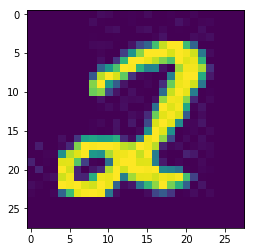

In [16]:
path = train_image_list[9001]
image = np.array(Image.open(path))
plt.imshow(image)

For MNIST, these would be "good" methods:

 * Hue / Saturation change
 * Rotation
 * Crop

Whereas these would be "bad" methods:

 * Flip horizontally
 * Flip vertically

<div class="alert alert-warning">
TODO Implement data augmentation
</div>

## Load Data: `data_loader.py`

Now our data is ready to be used for training. The only thing left is to load it to the model! There are multiple methods to load the data. We will use **tf.data** method recommended by TensorFlow.

### Dataset

First, we need to create a list of labels like the list of images.

In [17]:
train_label_list = [int_to_onehot(get_label_from_path(path)).tolist() for path in train_image_list]

In [18]:
train_image_list[0], train_label_list[0]

('data/mnist/train/8/img_3087.jpg', [0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

Now we can use `tf.data.Dataset` to create a dataset.

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((train_image_list, train_label_list))

Let's add configurations to our `dataset`. We want to use minibatches for efficiency.

In [20]:
BATCH_SIZE = 4
dataset = dataset.batch(BATCH_SIZE)

To avoid overfitting, we shuffle the dataset. In `dataset.shuffle()`, we need to specify a parameter called `buffer_size`. This is a shuffling method where the dataset randomly chooses from a buffer with a specified size rather than the full dataset for speed. If the size of the buffer is bigger than the size of the dataset, you get a uniformly random sample.

In [21]:
dataset = dataset.shuffle(buffer_size=1000)

### Iterator

Now, let's make an iterator to use the `tf.data.Dataset` object we defined. We use the **one shot iterator**, the simplest iterator that does not allow changing source of data.

In [22]:
iter = dataset.make_one_shot_iterator()

The iterator has a `iter.get_next()` function that returns the next element. In our case, we specified a `BATCH_SIZE`, so we are given one batch.

In [23]:
el = iter.get_next()

In [24]:
with tf.Session() as sess:
    print(sess.run(el))

(array([b'data/mnist/train/8/img_34197.jpg',
       b'data/mnist/train/8/img_32513.jpg',
       b'data/mnist/train/8/img_22575.jpg',
       b'data/mnist/train/8/img_26740.jpg'], dtype=object), array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=int32))


## References

`data_loader.py`
 * [How to use dataset in TensorFlow](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428)